In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from networkx.algorithms.community import modularity

gold_standard = pd.read_csv("gold-standard.tsv",sep='\t',index_col=0)
#all gene names
row_index = gold_standard.index.values
#all tf names
col_index = gold_standard.columns.values
#convert to edgelist
edgelist = [[tf,row_index[index],gold_standard[tf][index]] \
            for tf in gold_standard for index in gold_standard[tf].to_numpy().nonzero()[0]]

#convert edgelist to pandas dataframe to create networkx graph easier
edgelist = pd.DataFrame(edgelist)
#rename cedgelist column name
edgelist.rename(columns={0: 'tf', 1: 'gene',2:'weight'}, inplace=True)
new_edgelist = [1 if w==-1 else 2 for w in edgelist['weight']]
edgelist['new_weight'] = new_edgelist
#create graph
DiG = nx.from_pandas_edgelist(edgelist,'tf','gene', edge_attr='weight',create_using=nx.DiGraph)
G = nx.from_pandas_edgelist(edgelist,'tf','gene', edge_attr=None,create_using=nx.Graph)

#label each node as either tf or gene
tf_dict = {tf:"tf" for tf in col_index}
gene_dict = {gene:"gene" for gene in row_index}
nx.set_node_attributes(G,tf_dict,name="type")
nx.set_node_attributes(G,gene_dict,name="type")
print("number of nodes:",len(list(G.nodes())))
print("number of edges:",len(list(G.edges())))


number of nodes: 1072
number of edges: 1403


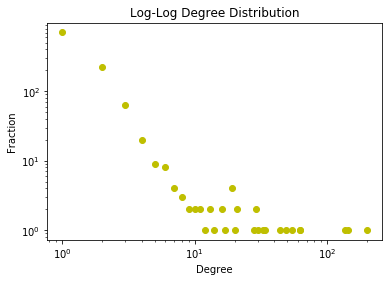

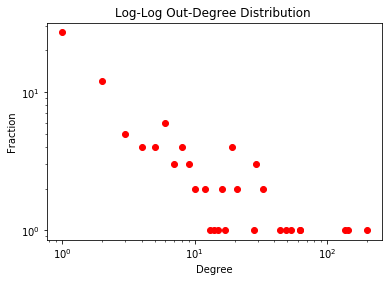

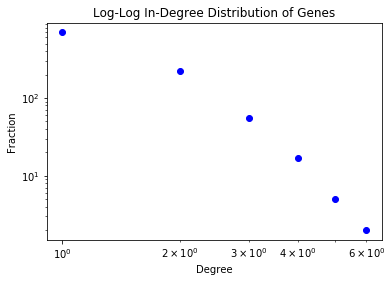

In [2]:
#degree distribution

outDegree_dict = dict(DiG.out_degree)
inDegree_dict = dict(DiG.in_degree)
tf_outDegree = {key : outDegree_dict[key] for key in outDegree_dict if key in col_index}
gene_inDegree = {key : inDegree_dict[key] for key in inDegree_dict if key in row_index}
tf_outDeg, tf_frac = zip(*Counter(tf_outDegree.values()).items())
gene_inDeg, gene_frac = zip(*Counter(gene_inDegree.values()).items())
degree_dict = dict(G.degree)
deg,frac = zip(*Counter(degree_dict.values()).items())
#plot degree distribution for both kind of nodes
plt.loglog(deg,frac,"yo",label="Gene")
plt.xlabel("Degree")
plt.ylabel("Fraction")
plt.title("Log-Log Degree Distribution")
plt.show()

plt.loglog(tf_outDeg,tf_frac,"ro",label="TF")
plt.xlabel("Degree")
plt.ylabel("Fraction")
plt.title("Log-Log Out-Degree Distribution ")
plt.show()

plt.loglog(gene_inDeg,gene_frac,"bo",label="Gene")
plt.xlabel("Degree")
plt.ylabel("Fraction")
plt.title("Log-Log In-Degree Distribution of Genes")
plt.show()

In [3]:
#size of connected components
for i in nx.connected_components(G):
    print(len(i))

1055
3
6
2
2
2
2


# Degree Analysis

In [43]:
import operator
#centrality
outDeg_cen = nx.out_degree_centrality(DiG)
inDeg_cen = nx.in_degree_centrality(DiG)
print("Max out degree centrality: ", sorted(outDeg_cen.items(), key=operator.itemgetter(1))[::-1][0])
print("Max in degree centrality: ", sorted(inDeg_cen.items(), key=operator.itemgetter(1))[::-1][0])
#degree_assortativity
print("Degree assortativity: ", nx.degree_assortativity_coefficient(G))
#clustering coefficient
print("Average Clustering Coefficient: ",nx.average_clustering(G))

Max out degree centrality:  ('YNL216W', 0.1858076563958917)
Max in degree centrality:  ('YOL058W', 0.0056022408963585435)
Degree assortativity:  -0.36315342722919464
Average Clustering Coefficient:  0.008095412160316014


# Louvain

In [195]:
import community
from networkx.algorithms.community import modularity, greedy_modularity_communities
#Louvain (Can only be used with undirected graph)
#we take the LCC
lcc = max(nx.connected_component_subgraphs(G), key=len)
part = community.best_partition(lcc)
# sorted_part = sorted(part.items(), key=operator.itemgetter(1))
print("Louvain number of communities detected: ",max(list(part.values()))+1)
# print("Modularity maximization number of communities detected: ",len(greedy_modularity_communities(lcc)))

#construct new partition list for Louvain
allPart_list = []
for i in range(max(list(part.values()))+1):
    part_list = []
    for key in part:
        if part[key] == i:
            part_list.append(key)
    allPart_list.append(part_list)
#modularity score of partitioning by Louvain
print("Modularity score: ", modularity(lcc,allPart_list))

Louvain number of communities detected:  20
Modularity score:  0.7355615151527423


In [218]:
#write out partition csv files
counter = 0
for i in allPart_list:
    i = pd.DataFrame(i)
    i.to_csv("louvain_part"+str(counter)+".csv",index=False,header=False)
    counter += 1

In [259]:
# write .gml file for each cluster for graphing in Gephi
counter = 0
for p in allPart_list:   
    subgraph = G.subgraph(p)
    nx.write_gml(subgraph,"louvain_subgraph"+str(counter)+".gml")
    counter+=1

# Spectral

In [229]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics

#Apply Spectral Clustering
lcc = max(nx.connected_component_subgraphs(G), key=len)
adj_mat = nx.to_numpy_matrix(lcc)
nodelist = list(lcc.nodes())
clusters = SpectralClustering(affinity = 'precomputed', assign_labels="discretize",random_state=0,n_clusters=20).fit_predict(adj_mat)


In [230]:
#Reformat clusters into dataframes
clusters = pd.DataFrame(clusters)
clusters.rename(columns={0:'clusters'},inplace=True)
nodelist = pd.DataFrame(nodelist)
nodelist.rename(columns={0:'node'},inplace=True)
spec_part = pd.concat([nodelist,clusters],axis=1)
spec_part.sort_values(by=['clusters'])

#Sort clusters and put them into a dictionary where the key is IDs and 
spec_part=spec_part.sort_values(by=['clusters'])
spec_nodeList = []
spec_clusterList = []
for i in spec_part['node']:
    spec_nodeList.append(i)
for j in spec_part['clusters']:
    spec_clusterList.append(j)
spec_allClusters = {spec_nodeList[i]:spec_clusterList[i] for i in range(len(spec_nodeList))}

#reformat cluster dictionary into new cluster list consisting of lists of node IDs
allClusters_list = []
for i in range(max(list(spec_allClusters.values()))+1):
    cluster_list = []
    for key in spec_allClusters:
        if spec_allClusters[key] == i:
            cluster_list.append(key)
    allClusters_list.append(cluster_list)
print("Modularity score: ",modularity(lcc,allClusters_list))

Modularity score:  0.7007203543792601


In [231]:
#write out node list csv files for GO term analysis
counter = 0
for i in allClusters_list:
    i = pd.DataFrame(i)
    i.to_csv("spectral_part"+str(counter)+".csv",index=False,header=False)
    counter += 1

In [260]:
#write out gml files for visualization
counter = 0
for p in allClusters_list:   
    subgraph = G.subgraph(p)
    nx.write_gml(subgraph,"spectral_subgraph"+str(counter)+".gml")
    counter+=1